### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Переходим к практике

In [141]:
import pandas as pd

Наши новости

In [142]:
news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GB/Machine-learning-in-business/lesson_2/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [143]:
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GB/Machine-learning-in-business/lesson_2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [144]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [145]:
# %pip install razdel
# %pip install pymorphy2
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [146]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [147]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [148]:
with open('/content/drive/MyDrive/Colab Notebooks/GB/Machine-learning-in-business/lesson_2/stopwords.txt', "r") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [149]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [150]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 27.6 s, sys: 487 ms, total: 28.1 s
Wall time: 28.1 s


In [151]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 47s, sys: 990 ms, total: 4min 48s
Wall time: 4min 48s


А теперь в 3 строчки обучим нашу модель

In [152]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [153]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [154]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 59.8 s, sys: 30.5 s, total: 1min 30s
Wall time: 56.9 s


In [155]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [212]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(5, 0.04217566), (10, 0.77673405), (13, 0.029536102), (20, 0.13106637)]

In [213]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: украина газ украинский киев миссия ступень разместить
topic_1: поверхность ресурс рейс производить опубликовать оплата участок
topic_2: корабль крым животное смерть день море чёрный
topic_3: всё наука университет очень статья жизнь проблема
topic_4: египет алкоголь страдать медицина офицер биолог ремонт
topic_5: nn луна место мкс рейтинг астронавт опухоль
topic_6: рост рынок цена проект млн снижение составить
topic_7: военный армия км производитель боевой операция войско
topic_8: ракета район советский ссср россия опубликовать граница
topic_9: взрыв турция исследователь древний великобритания земля отряд
topic_10: температура первый запуск двигатель пенсия космический всё
topic_11: банк научный учёный млрд система экономика исследователь
topic_12: обнаружить турист ребёнок тело дом найти земля
topic_13: продукция ветер фильм перевод содержать ндс польский
topic_14: самолёт объект сша исследование восток штат полёт
topic_15: рубль россия правительство фонд российский nn руб
top

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [158]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [214]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.013746,0.0,0.000000,0.038471,0.000000,0.0,0.0,0.0,0.0,0.184006,0.0,0.0,0.000000,0.000000,0.252509,0.045406,0.000000,0.00000,0.0,0.000000,0.459476,0.0,0.000000,0.0
1,4896,0.000000,0.000000,0.0,0.000000,0.000000,0.042049,0.0,0.0,0.0,0.0,0.837406,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.099082,0.0,0.000000,0.0
2,4897,0.000000,0.000000,0.0,0.000000,0.000000,0.042244,0.0,0.0,0.0,0.0,0.776384,0.0,0.0,0.029526,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.131358,0.000000,0.0,0.000000,0.0
3,4898,0.000000,0.000000,0.0,0.210369,0.000000,0.069597,0.0,0.0,0.0,0.0,0.263035,0.0,0.0,0.000000,0.000000,0.050122,0.145659,0.000000,0.25217,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,4899,0.034183,0.317714,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.057584,0.466820,0.000000,0.031465,0.00000,0.0,0.000000,0.000000,0.0,0.071694,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [215]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [216]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [217]:
doc_dict[293622]

array([0.        , 0.        , 0.11337657, 0.        , 0.01340865,
       0.12282548, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.12007386, 0.11369201, 0.        , 0.        ,
       0.        , 0.        , 0.19495954, 0.        , 0.03953385,
       0.        , 0.        , 0.05332864, 0.10300913, 0.11934067])

In [279]:
user_articles_list = users['articles'].iloc[23]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    print(user_vector)
    user_vector = np.max(user_vector, 0)
    return user_vector

In [280]:
user_vector = get_user_embedding(user_articles_list)
print(f'Результат {user_vector}')

[[0.         0.         0.14801317 0.         0.         0.
  0.         0.         0.08381031 0.02994232 0.         0.
  0.23930117 0.         0.         0.         0.         0.
  0.13057914 0.32184306 0.         0.03119162 0.         0.
  0.        ]
 [0.         0.         0.31670517 0.         0.         0.16471466
  0.         0.         0.         0.         0.05608067 0.
  0.         0.         0.         0.         0.         0.10846143
  0.         0.16540337 0.         0.         0.         0.
  0.16628174]
 [0.04106514 0.         0.08289863 0.01070745 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.23112775 0.         0.
  0.         0.0302479  0.         0.5972864  0.         0.
  0.        ]
 [0.0110653  0.         0.         0.         0.01750999 0.10234948
  0.         0.         0.         0.01242254 0.         0.
  0.         0.         0.         0.35949686 0.         0.
  0.         0.05513137 0.        

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [273]:
users['articles'].iloc[23]

'[323368, 321993, 323512, 322461, 324603, 169]'

In [278]:
" ".join(news[news['doc_id']==293622]['title'].iloc[0])

'звезда бродвей преддверие сочинский олимпиада опубликовать интернет пародийный мюзикл любовь наказание love punishment высмеивать закон запрет пропаганда гомосексуализм среди несовершеннолетний nhuffington postnn согласно сюжет видео власть закрывать российский бродвей поскольку всё спектакль носить пропаганда гомосексуализм ответ актёр ставить спектакль рассказываться история однополый пара разный эпоха российский история nn мюзикл присутствовать персонаж владимир путин чей жена замысел автор уходить женщина супружеский измена вымышленный путин рвать рубашка выступать против лгбтсообщество режиссёр ролик выступить джон уолтон уэст композитор джейсон майкл сноу видео сняться известный актёр бродвей джонатан грофф майкл ури эндрю рэннеллс каждый открытый гей'

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [167]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.082215,0.015851,0.040427,0.031290,0.010100,0.020471,0.035659,0.029475,0.043792,0.029728,0.001704,0.062701,0.100191,0.039317,0.000000,0.005102,0.056132,0.057920,0.000000,0.036768,0.088320,0.053700,0.035634,0.017167,0.092983
1,u108690,0.082364,0.004764,0.000000,0.132132,0.000000,0.000000,0.030529,0.007917,0.028869,0.006355,0.001825,0.094706,0.067710,0.026006,0.003446,0.068779,0.030749,0.006466,0.085213,0.016058,0.032493,0.102689,0.030040,0.006238,0.120761
2,u108339,0.019434,0.000000,0.041786,0.032189,0.006204,0.060201,0.011568,0.010385,0.010389,0.011059,0.039167,0.030802,0.105111,0.002334,0.008225,0.143918,0.018306,0.016321,0.013184,0.049540,0.007458,0.147849,0.026022,0.008727,0.170728


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [272]:
target = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GB/Machine-learning-in-business/lesson_2/users_churn.csv")
target.iloc[23:30]

,uid,churn
23,u108761,1
24,u103621,0
25,u106474,0
26,u108925,1
27,u104325,0
28,u101472,0
29,u106404,0


In [169]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.082215,0.015851,0.040427,0.031290,0.010100,0.020471,0.035659,0.029475,0.043792,0.029728,0.001704,0.062701,0.100191,0.039317,0.000000,0.005102,0.056132,0.057920,0.000000,0.036768,0.088320,0.053700,0.035634,0.017167,0.092983,0
1,u108690,0.082364,0.004764,0.000000,0.132132,0.000000,0.000000,0.030529,0.007917,0.028869,0.006355,0.001825,0.094706,0.067710,0.026006,0.003446,0.068779,0.030749,0.006466,0.085213,0.016058,0.032493,0.102689,0.030040,0.006238,0.120761,1
2,u108339,0.019434,0.000000,0.041786,0.032189,0.006204,0.060201,0.011568,0.010385,0.010389,0.011059,0.039167,0.030802,0.105111,0.002334,0.008225,0.143918,0.018306,0.016321,0.013184,0.049540,0.007458,0.147849,0.026022,0.008727,0.170728,1


In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [171]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [172]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [173]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08914617, 0.01214985, 0.35271397, 0.35702591, 0.18411685,
       0.0461856 , 0.26611732, 0.14930137, 0.05484354, 0.19481717])

In [174]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [175]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.250397, F-Score=0.643, Precision=0.619, Recall=0.669


In [176]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1654  101]
 [  82  163]]


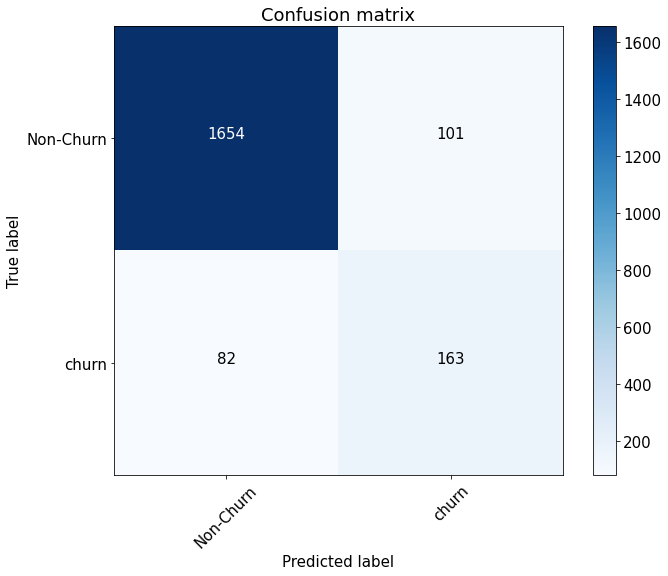

In [177]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [178]:
roc_auc_score(y_test, preds)

0.9337031222745508

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

In [186]:
def get_user_embedding_2(user_articles_list, func="mean"):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if func == "mean": 
      user_vector = np.mean(user_vector, 0)
    elif func == "median":
      user_vector = np.median(user_vector, 0)
    elif func == "max":
      user_vector = np.max(user_vector, 0) 
    return user_vector

In [285]:
def train_model(func):
  user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_2(x, func), 1)])
  user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
  user_embeddings['uid'] = users['uid'].values
  user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

  X = pd.merge(user_embeddings, target, 'left')

  #разделим данные на train/test
  X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                      X['churn'], random_state=0)

  logreg = LogisticRegression()
  #обучим 
  logreg.fit(X_train, y_train)


  #наши прогнозы для тестовой выборки
  preds = logreg.predict_proba(X_test)[:, 1]

  precision, recall, thresholds = precision_recall_curve(y_test, preds)
  fscore = (2 * precision * recall) / (precision + recall)

  # locate the index of the largest f score
  ix = np.argmax(fscore)
  rocauc_score = roc_auc_score(y_test, preds)
  print('Best F-Score=%.3f, Precision=%.3f, Recall=%.3f, roc auc score=%.3f' % (fscore[ix],
                                                                          precision[ix],
                                                                          recall[ix],
                                                                          rocauc_score))
  
  # cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
  # plt.figure(figsize=(10, 8))
  # plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
  #                       title='Confusion matrix')
  # plt.savefig("conf_matrix.png")
  # plt.show()

In [286]:
train_model("mean")
train_model("median")
train_model("max")

Best F-Score=0.642, Precision=0.620, Recall=0.665, roc auc score=0.934
Best F-Score=0.725, Precision=0.666, Recall=0.796, roc auc score=0.959
Best F-Score=0.738, Precision=0.746, Recall=0.731, roc auc score=0.958


Получается более выигрышно смотрится модель, обученная на эмбедингах полученных исходя из максимального отнашения к темам, прочитанных документов(статей). Можно еще сказать исходя из максимальных коэффициентов отношения прочитанных документов к темам.